In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
pval_threshold = 1e-2
output_dir = "."

encoder_comparisons = list(Path("outputs/encoder_comparison").glob("*/*/*/*"))

In [4]:
output_dir = Path(output_dir)

In [5]:
encoder_comparison_names = ["dataset", "subject", "model2", "model1"]
encoder_comparisons = [Path(p) for p in encoder_comparisons]
encoder_comparison_keys = [(path.parts[-4], path.parts[-3], path.parts[-2], path.parts[-1]) for path in encoder_comparisons]

In [6]:
for p in encoder_comparisons:
    df = pd.read_csv(p / "ttest_results.csv")
    if len(df.columns) != 4:
        print(p, df.columns)

outputs/encoder_comparison/timit-no_repeats/EC282/baseline/ph-ls-word_broad_fixed-w2v2_8-discrim2-l2norm Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC282/phoneme-w2v2_8-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC282/random8-w2v2_8-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC282/ph-ls-phoneme-w2v2_8-discrim1-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC282/ph-ls-word_broad-w2v2_8-discrim2-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC282/ph-ls-word_broad-w2v2_8-discrim1-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC282/ph-ls-phoneme-w2v2_8-discrim2-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC282/random32-w2v2_8-l2norm/base

outputs/encoder_comparison/timit-no_repeats/EC287/ph-ls-phoneme-w2v2_8-discrim2-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC242/ph-ls-phoneme-w2v2_8-discrim2-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC242/random8-w2v2_8-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC242/baseline/ph-ls-word_broad_fixed-w2v2_8-discrim2-l2norm Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC242/ph-ls-word_broad-w2v2_8-discrim2-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC242/phoneme-w2v2_8-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC242/random32-w2v2_8-l2norm/baseline Index(['Unnamed: 0'], dtype='object')
outputs/encoder_comparison/timit-no_repeats/EC242/ph-ls-word_broad-w2v2_8-discrim1-l2norm/base

In [7]:
all_ttest_results = [pd.read_csv(path / "ttest_results.csv")
                     for path in encoder_comparisons]
keep_result = [len(df) > 0 for df in all_ttest_results]
all_ttest_results = [df for df, keep in zip(all_ttest_results, keep_result) if keep]
all_ttest_keys = [key for key, keep in zip(encoder_comparison_keys, keep_result) if keep]

all_ttest_results = pd.concat(
    all_ttest_results,
    names=encoder_comparison_names,
    keys=all_ttest_keys)
all_ttest_results["output_dim"] = all_ttest_results.output_dim.astype(int)
all_ttest_results.to_csv(output_dir / "ttest.csv")
all_ttest_results

ValueError: No objects to concatenate

In [84]:
all_scores_df = pd.concat([
        # whoops, output_name is a tuple -- let's read it as such
        pd.read_csv(path / "scores.csv", converters={"output_name": ast.literal_eval}) for path in encoder_comparisons
    ], keys=encoder_comparison_keys, names=encoder_comparison_names) \
    .reset_index(level=-1, drop=True)
all_scores_df["electrode_name"] = all_scores_df.output_name.str[1]
all_scores_df = all_scores_df.set_index("electrode_name", append=True)
all_scores_df.to_csv(output_dir / "scores.csv")
all_scores_df

model  \
dataset          subject model2                    model1   electrode_name             
timit-no_repeats EC152   ph-syllable-w2v2_8-l2norm baseline G1              baseline   
                                                            G1              baseline   
                                                            G1              baseline   
                                                            G2              baseline   
                                                            G2              baseline   
...                                                                              ...   
                 EC253   random8                   baseline PG127            random8   
                                                            PG127            random8   
                                                            PG128            random8   
                                                            PG128            random8   
                                                            PG128            random8   

                                                                            output_dim  \
dataset          subject model2                    model1   electrode_name               
timit-no_repeats EC152   ph-syllable-w2v2_8-l2norm baseline G1                       0   
                                                            G1                       0   
                                                            G1                       0   
                                                            G2                       1   
                                                            G2                       1   
...                                                                                ...   
                 EC253   random8                   baseline PG127                  254   
                                                            PG127                  254   
                                                            PG128                  255   
                                                            PG128                  255   
                                                            PG128                  255   

                                                                            fold  \
dataset          subject model2                    model1   electrode_name         
timit-no_repeats EC152   ph-syllable-w2v2_8-l2norm baseline G1                 0   
                                                            G1                 1   
                                                            G1                 2   
                                                            G2                 0   
                                                            G2                 1   
...                                                                          ...   
                 EC253   random8                   baseline PG127              1   
                                                            PG127              2   
                                                            PG128              0   
                                                            PG128              1   
                                                            PG128              2   

                                                                               score  \
dataset          subject model2                    model1   electrode_name             
timit-no_repeats EC152   ph-syllable-w2v2_8-l2norm baseline G1             -0.001135   
                                                            G1             -0.001564   
                                                            G1             -0.007084   
                                                            G2              0.001129   
                                                            G2              0.002411   
...                                                   

In [85]:
all_electrodes_keys = [(dataset, subject, model2) for dataset, subject, model2, model1 in encoder_comparison_keys]
all_electrodes_paths = [Path("outputs/encoders") / dataset / model2 / subject / "electrodes.csv"
                        for dataset, subject, model2 in all_electrodes_keys]
all_electrodes_df = pd.concat([
        pd.read_csv(path) for path in all_electrodes_paths
    ], keys=all_electrodes_keys, names=["dataset", "subject", "model"]) \
    .droplevel(-1)
all_electrodes_df.to_csv(output_dir / "electrodes.csv")
all_electrodes_df

electrode_idx  \
dataset          subject model                                      
timit-no_repeats EC152   ph-syllable-w2v2_8-l2norm              0   
                         ph-syllable-w2v2_8-l2norm              1   
                         ph-syllable-w2v2_8-l2norm              2   
                         ph-syllable-w2v2_8-l2norm              3   
                         ph-syllable-w2v2_8-l2norm              4   
...                                                           ...   
                 EC253   random8                              311   
                         random8                              312   
                         random8                              313   
                         random8                              314   
                         random8                              315   

                                                   electrode_name  \
dataset          subject model                                      
timit-no_repeats EC152   ph-syllable-w2v2_8-l2norm             G1   
                         ph-syllable-w2v2_8-l2norm             G2   
                         ph-syllable-w2v2_8-l2norm             G3   
                         ph-syllable-w2v2_8-l2norm             G4   
                         ph-syllable-w2v2_8-l2norm             G5   
...                                                           ...   
                 EC253   random8                             PST2   
                         random8                             PST3   
                         random8                             PST4   
                         random8                             PST5   
                         random8                             PST6   

                                                                long_name  \
dataset          subject model                                              
timit-no_repeats EC152   ph-syllable-w2v2_8-l2norm        RGridElectrode1   
                         ph-syllable-w2v2_8-l2norm        RGridElectrode2   
                         ph-syllable-w2v2_8-l2norm        RGridElectrode3   
                         ph-syllable-w2v2_8-l2norm        RGridElectrode4   
                         ph-syllable-w2v2_8-l2norm        RGridElectrode5   
...                                                                   ...   
                 EC253   random8                    PosteriorSubtemporal2   
                         random8                    PosteriorSubtemporal3   
                         random8                    PosteriorSubtemporal4   
                         random8                    PosteriorSubtemporal5   
                         random8                    PosteriorSubtemporal6   

                                                     type               roi  
dataset          subject model                                               
timit-no_repeats EC152   ph-syllable-w2v2_8-l2norm   grid    middletemporal  
                         ph-syllable-w2v2_8-l2norm   grid    middletemporal  
                         ph-syllable-w2v2_8-l2norm   grid  superiortemporal  
                         ph-syllable-w2v2_8-l2norm   grid  superiortemporal  
                         ph-syllable-w2v2_8-l2norm   grid  superiortemporal  
...                                                   ...               ...  
                 EC253   random8                    strip          fusiform  
                         random8                    strip  inferiortemporal  
                         random8                    strip  inferiortemporal  
                         random8                    strip  inferiortemporal  
                         random8                    strip    middletemporal  

[85580 rows x 5 columns]

<Axes: xlabel='model', ylabel='subject'>

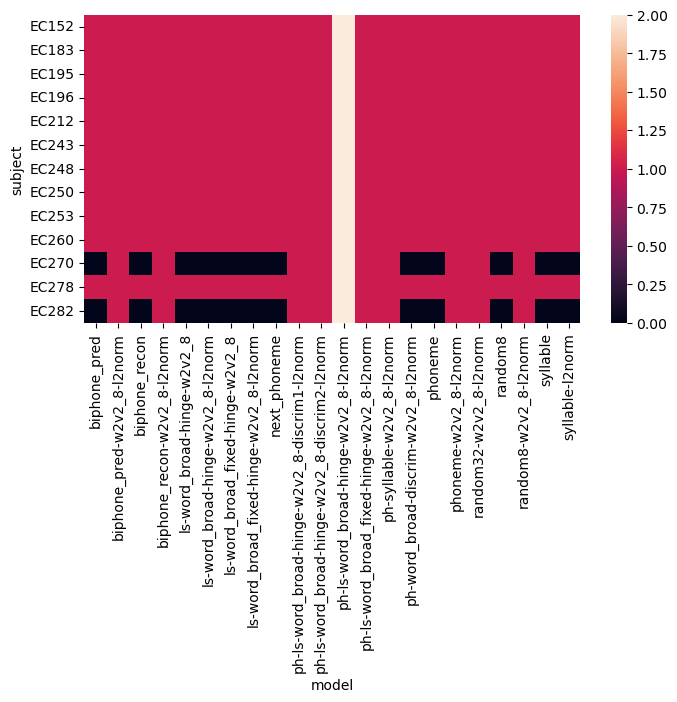

In [86]:
covered_models = sorted(all_ttest_results.index.get_level_values("model2").unique())
covered_subjects = sorted(all_ttest_results.index.get_level_values("subject").unique())
coverage_df = pd.DataFrame(np.zeros((len(covered_subjects), len(covered_models)), dtype=int),
                           columns=pd.Index(covered_models, name="model"),
                            index=pd.Index(covered_subjects, name="subject"))
for dataset, subject, model2, model1 in encoder_comparison_keys:
    try:
        coverage_df.loc[subject, model2] += 1
    except KeyError:
        print(f"Missing all data for {subject}?")
        pass
f, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(coverage_df, fmt=",d")

## Electrode selection

In [92]:
# For each dataset-subject-model1-model2-electrode, take the permutation which yields the LARGEST pvalue
# This is a more stringent test of improvement
ttest_results_filtered = all_ttest_results.dropna().groupby(["dataset", "subject", "model2", "model1", "output_dim"]).apply(lambda df: df.loc[df.pval.idxmax()])
ttest_results_filtered = ttest_results_filtered[(ttest_results_filtered.tval > 0) & (ttest_results_filtered.pval < pval_threshold)] \
    .sort_values("pval")
ttest_results_filtered.to_csv(Path(output_dir) / "ttest_filtered.csv")
ttest_results_filtered

/tmp/ipykernel_3025544/1625047910.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ttest_results_filtered = all_ttest_results.dropna().groupby(["dataset", "subject", "model2", "model1", "output_dim"]).apply(lambda df: df.loc[df.pval.idxmax()])


output_dim  \
dataset          subject model2                                        model1   output_dim               
timit-no_repeats EC152   biphone_pred                                  baseline 165                165   
                 EC260   biphone_pred                                  baseline 206                206   
                         phoneme                                       baseline 206                206   
                 EC278   biphone_pred                                  baseline 37                  37   
                 EC152   ph-word_broad-discrim-w2v2_8-l2norm           baseline 165                165   
...                                                                                                ...   
                         random8                                       baseline 11                  11   
                 EC250   ls-word_broad-hinge-w2v2_8                    baseline 24                  24   
                 EC278   ph-ls-word_broad-hinge-w2v2_8-discrim2-l2norm baseline 115                115   
                 EC248   random8                                       baseline 191                191   
                 EC195   syllable-l2norm                               baseline 158                158   

                                                                                           permutation  \
dataset          subject model2                                        model1   output_dim               
timit-no_repeats EC152   biphone_pred                                  baseline 165              shift   
                 EC260   biphone_pred                                  baseline 206              shift   
                         phoneme                                       baseline 206              shift   
                 EC278   biphone_pred                                  baseline 37               shift   
                 EC152   ph-word_broad-discrim-w2v2_8-l2norm           baseline 165              shift   
...                                                                                                ...   
                         random8                                       baseline 11               shift   
                 EC250   ls-word_broad-hinge-w2v2_8                    baseline 24               shift   
                 EC278   ph-ls-word_broad-hinge-w2v2_8-discrim2-l2norm baseline 115              shift   
                 EC248   random8                                       baseline 191              shift   
                 EC195   syllable-l2norm                               baseline 158              units   

                                                                                                   tval  \
dataset          subject model2                                        model1   output_dim                
timit-no_repeats EC152   biphone_pred                                  baseline 165         1741.812103   
                 EC260   biphone_pred                                  baseline 206         1443.134469   
                         phoneme                                       baseline 206         1039.156371   
                 EC278   biphone_pred                                  baseline 37           664.070157   
                 EC152   ph-word_broad-discrim-w2v2_8-l2norm           baseline 165          591.855116   
...                                                                                                 ...   
                         random8                                       baseline 11             4.608123   
                 EC250   ls-word_broad-hinge-w2v2_8                    baseline 24             4.606555   
                 EC278   ph-ls-word_broad-hinge-w2v2_8-discrim2-l2norm baseline 115            9.932768   
                 EC248   random8                                       baseline 191            4.605120   
                 EC195   syllable-l2norm          

## Summary quantitative analysis

In [ ]:
all_scores_df

In [ ]:
# # plot baseline performance
# baseline_scores = all_scores_df.xs("baseline", level="model")
# plot_df = baseline_scores.groupby(["subject", "electrode_roi", "electrode_name"]).score.mean().reset_index()

# f, ax = plt.subplots(figsize=(15, 8))
# sns.barplot(data=plot_df, x="subject", y="score", ax=ax)
# ax.set_title("Mean baseline r^2 by subject, across all electrodes")

In [ ]:
# # plot baseline performance
# baseline_scores = all_scores_df.xs("baseline", level="model")
# plot_df = baseline_scores.groupby(["subject", "fold"]).score.max().reset_index()

# f, ax = plt.subplots(figsize=(15, 8))
# sns.barplot(data=plot_df, x="subject", y="score", ax=ax)
# ax.set_title("Max baseline r^2 by subject, across all electrodes")

In [ ]:
# def compute_improvement_within_fold(fold_df):
#     print(fold_df.score)
#     ret = fold_df.score - fold_df.xs("baseline", level="model").score
#     print(ret)
#     return ret

# # all_scores_df.groupby(["subject", "output_name"]).apply(compute_improvement_within_fold)
# improvement_df = all_scores_df.set_index(["fold", "output_name"], append=True)
# improvement_df = pd.merge(improvement_df, (improvement_df.score - improvement_df.xs("baseline", level="model").score).rename("improvement"),
#                           left_index=True, right_index=True)
# improvement_df = improvement_df.loc[improvement_df.index.get_level_values("model") != "baseline"]
# improvement_df

In [ ]:
# improvement_df.groupby(["subject", "output_name", "model"]).improvement.mean().sort_values(ascending=False)

In [ ]:
# f, ax = plt.subplots(figsize=(15, 8))
# plot_df = improvement_df.groupby(["subject", "model", "output_name"]).improvement.mean().reset_index()
# sns.boxplot(data=plot_df, order=plot_df.groupby("model").improvement.mean().sort_values(ascending=False).index,
#             x="model", y="improvement", hue="subject", ax=ax)

In [ ]:
# f, ax = plt.subplots(figsize=(15, 8))
# plot_df = improvement_df.groupby(["subject", "model", "output_name"]).improvement.mean().reset_index()
# sns.barplot(data=plot_df, order=plot_df.groupby("subject").improvement.mean().sort_values(ascending=False).index,
#             x="subject", y="improvement", hue="model", ax=ax)
# ax.set_title("Mean improvement across electrodes within subject and model")

In [ ]:
# f, ax = plt.subplots(figsize=(15, 8))
# plot_df = improvement_df.groupby(["subject", "model", "fold"]).improvement.max().reset_index()
# sns.barplot(data=plot_df, order=plot_df.groupby("subject").improvement.mean().sort_values(ascending=False).index,
#             x="subject", y="improvement", hue="model", ax=ax)
# ax.set_title("Max improvement across electrodes within subject and model")

In [ ]:
plot_df = all_electrodes_df.roi.value_counts()
plot_df = plot_df[plot_df / plot_df.sum() >= 0.01]
ax = sns.barplot(data=plot_df)
ax.set_title("Number of electrodes per ROI")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
None

In [ ]:
# f, ax = plt.subplots(figsize=(15, 8))
# sns.barplot(data=improvement_df.reset_index(),
#             x="model", y="improvement", hue="electrode_roi", ax=ax)
# ax.set_title("Mean improvement across subject, electrode within ROI and model")

In [ ]:
# f, ax = plt.subplots(figsize=(15, 8))
# sns.barplot(data=improvement_df.reset_index(),
#             order=improvement_df.reset_index().groupby("electrode_roi").improvement.mean().sort_values(ascending=False).index,
#             x="electrode_roi", y="improvement", hue="model",
#             ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# ax.set_title("Mean improvement across subject, electrode within ROI and model")

In [ ]:
# f, ax = plt.subplots(figsize=(15, 8))
# plot_df = improvement_df.groupby(["subject", "electrode_roi", "model", "fold"]).improvement.max().reset_index()
# sns.barplot(data=plot_df,
#             order=plot_df.groupby("electrode_roi").improvement.mean().sort_values(ascending=False).index,
#             x="electrode_roi", y="improvement", hue="model",
#             ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# ax.set_title("Max improvement across subject, electrode within ROI and model")